In [18]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, norm, ttest_ind
import numpy as np
from tqdm.auto import tqdm

# Задание 1
# Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

In [30]:
# Прочитаем датафреймы, при проверке оказалось что нужен разделитель ';'

auth_df = pd.read_csv('/Users/sergejegolaev/Work/KC/fin_project/problem1-auth_data.csv', sep=';')
reg_df = pd.read_csv('/Users/sergejegolaev/Work/KC/fin_project/problem1-reg_data.csv', sep=';')

Посмотрим на содержимое файлов

In [5]:
auth_df.head(3)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2


In [6]:
reg_df.head(3)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3


In [7]:
auth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [8]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [9]:
auth_df.describe()

,auth_ts,uid
count,9.601013e+06,9.601013e+06
mean,1.548778e+09,3.347198e+05
std,5.160527e+07,2.832669e+05
min,9.113822e+08,1.000000e+00
25%,1.528375e+09,9.599700e+04
50%,1.564577e+09,2.579210e+05
75%,1.585823e+09,5.190250e+05
max,1.600874e+09,1.110622e+06


In [10]:
reg_df.describe()

,reg_ts,uid
count,1.000000e+06,1.000000e+06
mean,1.548332e+09,5.552354e+05
std,5.253653e+07,3.206011e+05
min,9.113822e+08,1.000000e+00
25%,1.528034e+09,2.776438e+05
50%,1.564454e+09,5.550455e+05
75%,1.585759e+09,8.329712e+05
max,1.600874e+09,1.110622e+06


In [11]:
auth_df.dtypes

auth_ts    int64
uid        int64
dtype: object

In [12]:
reg_df.dtypes

reg_ts    int64
uid       int64
dtype: object

Соеденим датафреймы для дальнейшей обработки и поиска необходимой метрики. Использую тип мерджа - лефт, потому что для рассчета метрики retention нас интересуют только те uid, по которым есть данные в датафрейме с регистрациями

In [13]:
merged_data = reg_df.merge(auth_df, how='left', on='uid')

In [14]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   reg_ts   int64
 1   uid      int64
 2   auth_ts  int64
dtypes: int64(3)
memory usage: 293.0 MB


In [15]:
# Поменяем местами колонки, удобнее работать с данными
merged_data = merged_data[['uid', 'reg_ts', 'auth_ts']]

In [16]:
# Приведем колонки с датами к верному формату
merged_data['reg_ts'] = pd.to_datetime(merged_data['reg_ts'], unit='s')
merged_data['auth_ts'] = pd.to_datetime(merged_data['auth_ts'], unit='s')

### Наиболее подходящим решением кажется когортный анализ (изучали в промежуточном проекте, как раз на примере RR)

In [17]:
# Для рассчета когорт приведем даты регистрации и данные о времени захода в игру к формату год-месяц-день
merged_data['auth_ts'] = merged_data['auth_ts'].dt.floor("D")
merged_data['reg_ts'] = merged_data['reg_ts'].dt.floor("D")

In [18]:
# Посчитаем разницу между датой регистрации и датой события
merged_data['ret_days'] = (merged_data['auth_ts'] - merged_data['reg_ts']).dt.days

In [19]:
merged_data

,uid,reg_ts,auth_ts,ret_days
0,1,1998-11-18,1998-11-18,0
1,2,1999-07-22,1999-07-22,0
2,2,1999-07-22,1999-07-25,3
3,2,1999-07-22,1999-07-31,9
4,2,1999-07-22,1999-08-05,14
...,...,...,...,...
9601008,1110618,2020-09-23,2020-09-23,0
9601009,1110619,2020-09-23,2020-09-23,0
9601010,1110620,2020-09-23,2020-09-23,0
9601011,1110621,2020-09-23,2020-09-23,0


## Соберем функцию, которая будет считать метрику и отображать когортный анализ по ней в зависимости от заданных параметров. Данная функция считает количество в процентах

In [36]:
def retention_rate(reg_df, auth_df, start, end, amount_days):
    # где reg_df, auth_df - датафреймы с данными регистрации и входа в игру, start и end период 
    # за который исследуем данные. Датафрейм с 10 млн строк, добавим возможность расчета RR за период. 
    # amount_days - количесвто дней за которые хотим посчитать метрику
   
    # Приведем даты и диапазон к нужному виду
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    amount_days = int(amount_days)
     
    # Соеденим датафреймы для дальнейшей обработки и поиска необходимой метрики. 
    # Использую тип мерджа - лефт, потому что для рассчета метрики retention нас 
    # интересуют только те uid, по которым есть данные в датафрейме с регистрациями
    merge_data = pd.merge(auth_df, reg_df, on='uid', how='left')
    
    # Приведем колонки с датами к верному формату
    merge_data['auth_ts'] = pd.to_datetime(merge_data['auth_ts'], unit='s').dt.floor("D")
    merge_data['reg_ts'] = pd.to_datetime(merge_data['reg_ts'], unit='s').dt.floor("D")    
    
    # Cоздаем столбец с количеством дней, прошедших с регистрации до входа в игру
    merge_data['days'] = (merge_data['auth_ts'] - merge_data['reg_ts']).dt.days
    
    # Приведем данные к нужному диапазону
    merge_data = merge_data[(merge_data['reg_ts'] >= start) &
                            (merge_data['reg_ts'] <= end) &
                            (merge_data['days'] <= amount_days)] 

    # Рассчитаем количество зарегестрированных пользователей по каждому дню
    retention_df = merge_data.groupby(['reg_ts', 'days']).agg(users=('uid', 'nunique')).reset_index()

    # Соберем данные в сводную таблицу
    pivot_retention = retention_df.pivot(index='reg_ts', columns='days', values='users').fillna(0).astype(int)
                      
    # Обозначим значение когорт, и поделим поэлементно значения в итоговой таблице на когорты
    cohort = pivot_retention.iloc[:, 0]
    retention = pivot_retention.divide(cohort, axis=0)
    retention[0] = cohort
    
    # Переименуем колонки для более удобного восприятия
    retention = retention.reset_index().rename(columns={0: 'users'}).set_index(['reg_ts', 'users'])
    
    # Настроим стиль отображения таблицы, чуть увеличим размер для лучшего чтения информации
    styles = [
        dict(selector="table", props=[("font-size", "120%")]),
        dict(selector="th", props=[("font-size", "120%")]),
        dict(selector="td", props=[("font-size", "120%")]),
    ]
    
    # Для более удобного восприятия картины, оформим всю таблицу в цетовой схеме, с отображением вместо значений
    # проценты Retantion
    retention = retention.iloc[:, 1:].style. \
        background_gradient(axis=None, cmap='coolwarm').format("{:.1%}").highlight_null('white')
    
    return retention.set_table_styles(styles)

In [37]:
retention_rate(reg_df, auth_df, '2020-09-01', '2020-09-15', 10)

,days,2,3,4,5,6,7,8,9,10
reg_ts,users,,,,,,,,,
2020-09-01 00:00:00,1586,4.1%,4.2%,4.6%,6.4%,5.6%,6.4%,4.1%,5.4%,5.1%
2020-09-02 00:00:00,1588,3.9%,4.7%,5.7%,6.2%,7.1%,6.3%,4.8%,4.1%,5.7%
2020-09-03 00:00:00,1591,5.4%,4.7%,6.5%,7.0%,8.5%,6.3%,5.5%,6.3%,6.3%
2020-09-04 00:00:00,1593,3.6%,3.6%,5.1%,6.4%,7.3%,5.0%,5.3%,4.3%,5.6%
2020-09-05 00:00:00,1596,3.9%,4.6%,5.5%,5.9%,7.5%,4.9%,5.1%,5.5%,6.0%
2020-09-06 00:00:00,1599,4.3%,5.4%,5.6%,5.9%,6.8%,6.1%,5.8%,5.5%,4.9%
2020-09-07 00:00:00,1601,4.2%,5.4%,5.1%,6.4%,7.3%,5.2%,4.1%,5.6%,6.0%
2020-09-08 00:00:00,1604,3.9%,3.9%,4.9%,7.6%,7.5%,6.6%,5.2%,5.2%,6.5%
2020-09-09 00:00:00,1607,3.2%,4.7%,5.7%,6.7%,5.7%,5.9%,4.4%,5.0%,3.7%


### Функция считает значение RR в процентах. Для отображения количественного показателя необходимо изменить часть кода 

In [42]:
def retention(reg_df, auth_df, start, end, amount_days):
    # где reg_df, auth_df - датафреймы с данными регистрации и входа в игру, start и end период 
    # за который исследуем данные. Датафрейм с 10 млн строк, добавим возможность расчета RR за период. 
    # amount_days - количесвто дней за которые хотим посчитать метрику
   
    # Приведем даты и диапазон к нужному виду
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    amount_days = int(amount_days)
     
    # Соеденим датафреймы для дальнейшей обработки и поиска необходимой метрики. 
    # Использую тип мерджа - лефт, потому что для рассчета метрики retention нас 
    # интересуют только те uid, по которым есть данные в датафрейме с регистрациями
    merge_data = pd.merge(auth_df, reg_df, on='uid', how='left')
    
    # Приведем колонки с датами к верному формату
    merge_data['auth_ts'] = pd.to_datetime(merge_data['auth_ts'], unit='s').dt.floor("D")
    merge_data['reg_ts'] = pd.to_datetime(merge_data['reg_ts'], unit='s').dt.floor("D")    
    
    # Cоздаем столбец с количеством дней, прошедших с регистрации до входа в игру
    merge_data['days'] = (merge_data['auth_ts'] - merge_data['reg_ts']).dt.days
    
    # Приведем данные к нужному диапазону
    merge_data = merge_data[(merge_data['reg_ts'] >= start) &
                            (merge_data['reg_ts'] <= end) &
                            (merge_data['days'] <= amount_days)]  

    # Рассчитаем количество зарегестрированных пользователей по каждому дню
    retention_df = merge_data.groupby(['reg_ts', 'days']).agg(users=('uid', 'nunique')).reset_index()

    # Соберем данные в сводную таблицу
    pivot_retention = retention_df.pivot(index='reg_ts', columns='days', values='users').fillna(0).astype(int)    
    # Переименуем колонки для более удобного восприятия
    pivot_retention = pivot_retention.reset_index().rename(columns={0: 'users'}).set_index(['reg_ts', 'users'])
    
    # Настроим стиль отображения таблицы, чуть увеличим размер для лучшего чтения информации
    styles = [
        dict(selector="table", props=[("font-size", "120%")]),
        dict(selector="th", props=[("font-size", "120%")]),
        dict(selector="td", props=[("font-size", "120%")]),
    ]
    
    # Для более удобного восприятия картины, оформим всю таблицу в цетовой схеме, с отображением вместо значений
    # проценты Retantion
    pivot_retention = pivot_retention.iloc[:, 0:].style. \
        background_gradient(axis=None, cmap='coolwarm').highlight_null('white')
    
    return pivot_retention.set_table_styles(styles)

In [43]:
retention(reg_df, auth_df, '2020-09-01', '2020-09-15', 10)

,days,1,2,3,4,5,6,7,8,9,10
reg_ts,users,,,,,,,,,,
2020-09-01 00:00:00,1586,32,65,67,73,102,89,102,65,86,81
2020-09-02 00:00:00,1588,40,62,74,90,99,113,100,77,65,90
2020-09-03 00:00:00,1591,37,86,75,104,111,136,101,87,100,101
2020-09-04 00:00:00,1593,32,58,58,82,102,116,79,85,69,90
2020-09-05 00:00:00,1596,44,63,74,87,94,119,78,81,87,96
2020-09-06 00:00:00,1599,50,69,87,90,94,109,97,93,88,78
2020-09-07 00:00:00,1601,47,68,86,81,102,117,84,66,90,96
2020-09-08 00:00:00,1604,28,63,63,78,122,121,106,83,83,105
2020-09-09 00:00:00,1607,28,52,75,92,107,92,95,70,81,60


# Задание 2
# Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

# Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?



In [39]:
# Прочитаем данные. При проверке так же оказалось что необходим разделитель

task2 = pd.read_csv('/Users/sergejegolaev/Work/KC/fin_project/Проект_1_Задание_2.csv', sep=';')

In [5]:
task2.head(3)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a


In [6]:
task2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [7]:
# Проверим дубли по пользователям, чтобы исключить попадание в обе группы
task2.user_id.duplicated().sum()

0

In [8]:
task2.query('testgroup == "b"').agg({"revenue": 'sum'})

revenue    5421603
dtype: int64

In [9]:
task2.query('testgroup == "a"').agg({"revenue": 'sum'})

revenue    5136189
dtype: int64

In [10]:
# Проверим действительно ли ARPU отличается на заявленные проценты

print("ARPU в тестовой группе на", ((1 - task2.query('testgroup == "a"')
      .agg({'revenue': 'sum'}) / task2.query('testgroup == "b"')
      .agg({'revenue': 'sum'})) * 100).revenue.round(2), "% больше, чем в контрольной группе")

ARPU в тестовой группе на 5.26 % больше, чем в контрольной группе


In [11]:
# Посмотрим на группы отдельно
control_data = task2.query('testgroup == "a"')
test_data = task2.query('testgroup == "b"')

In [12]:
control_data.revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [13]:
# Посчитаем ARPU контрольной группы
contr_arpu = control_data.revenue.describe().loc['mean']
contr_arpu

25.413719736965806

In [14]:
test_data.revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [15]:
# Посчитаем ARPU тестовой группы
test_arpu = test_data.revenue.describe().loc['mean']
test_arpu

26.75128659327863

Теперь посмотрим на данные по платящим пользователям

In [16]:
control_pay = task2.query('testgroup == "a" & revenue > 0')
test_pay = task2.query('testgroup == "b" & revenue > 0')

In [17]:
control_pay.describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [18]:
test_pay.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


Text(0.5, 1.0, 'Cравнение платящих пользователей')

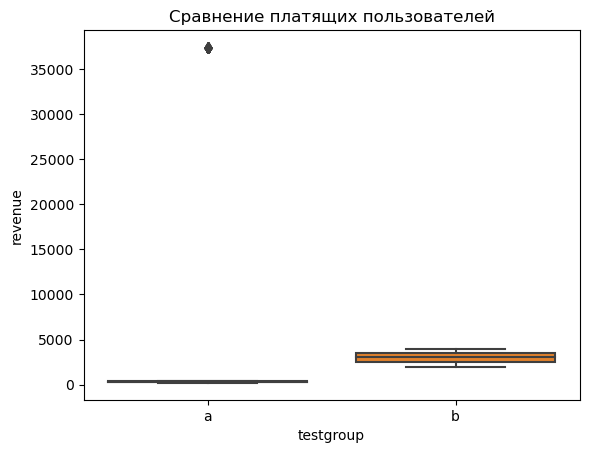

In [19]:
sns.boxplot(data=task2.query("revenue > 0"), x="testgroup", y="revenue")
plt.title("Cравнение платящих пользователей")

Text(0.5, 1.0, 'Cравнение платящих пользователей')

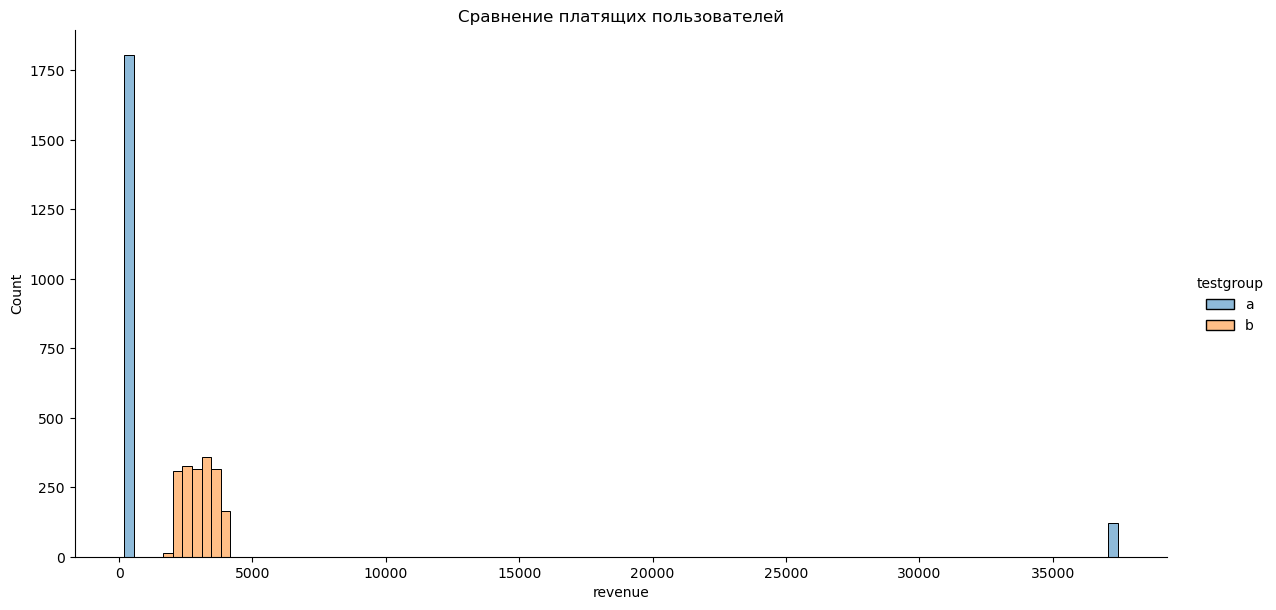

In [20]:
sns.displot(data=task2.query("revenue > 0"), x="revenue", hue="testgroup", height=6, aspect=2)
plt.title("Cравнение платящих пользователей")

В контрольной группе есть выбросы которые формируют АРПУ и средний чек на близком уровне, посмотрим на распределение без них

Text(0.5, 1.0, 'Cравнение платящих пользователей без выбросов')

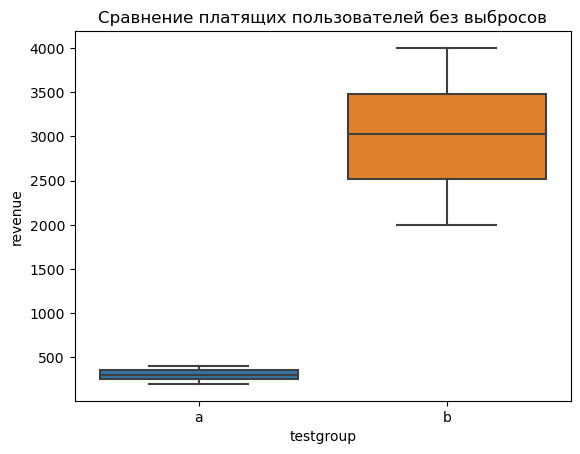

In [24]:
sns.boxplot(data=task2.query("revenue > 0 & revenue < 15000"), x='testgroup', y='revenue')
plt.title("Cравнение платящих пользователей без выбросов")

Text(0.5, 1.0, 'Cравнение платящих пользователей без выбросов')

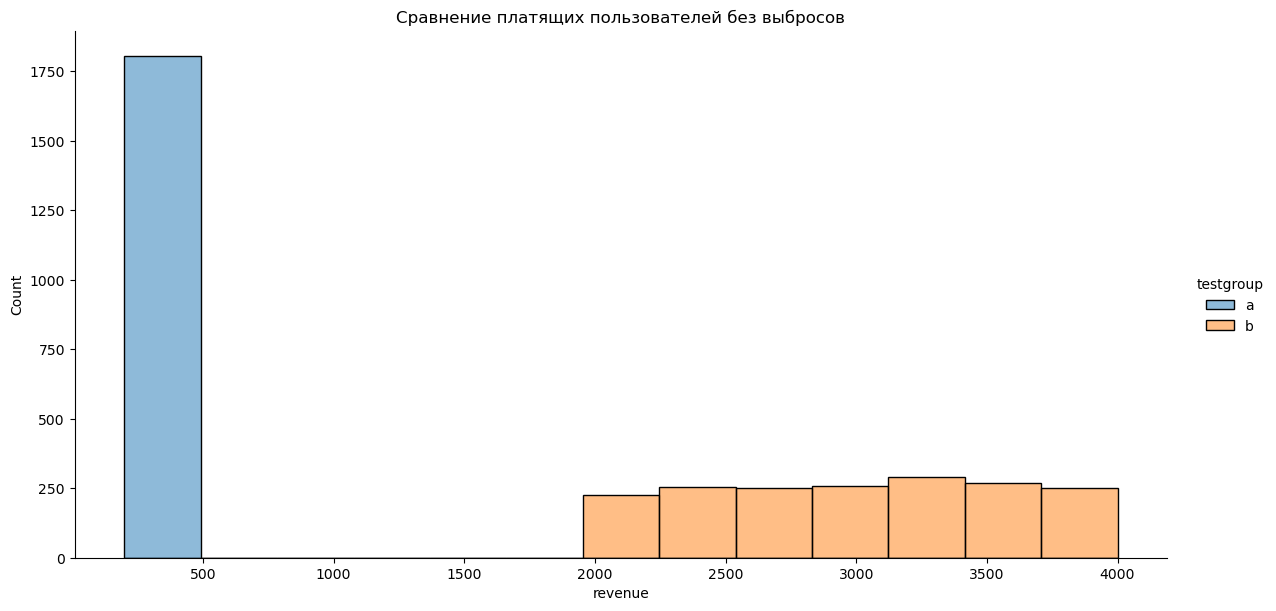

In [22]:
sns.displot(data=task2.query("revenue > 0 & revenue < 15000"), x="revenue", hue="testgroup", height=6, aspect=2)
plt.title("Cравнение платящих пользователей без выбросов")

Посмотрим на данные без выбросов. Выбросы есть только в контрольной группе, поэтому дополнительно фильтровать необходимо только ее

In [23]:
control_pay_out_anomaly = task2.query('testgroup == "a" & revenue > 0 & revenue < 15000')
test_pay_out_anomaly = task2.query('testgroup == "b" & revenue > 0')

In [24]:
control_pay_out_anomaly.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,199923.686981,302.458172
std,116615.234772,57.914246
min,73.000000,200.000000
25%,98963.000000,254.000000
50%,199268.000000,305.000000
75%,298918.000000,352.000000
max,404768.000000,400.000000


In [25]:
control_pay_out_anomaly.revenue.sum()

545937

In [26]:
test_pay_out_anomaly.revenue.sum()

5421603

In [27]:
test_pay_out_anomaly.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


In [28]:
# Количество пользователей в контрольной группе
len(task2[(task2['testgroup'] == 'a')])

202103

In [29]:
# Количество пользователей в тестовой группе
len(task2[(task2['testgroup'] == 'b')])

202667

In [30]:
# Количество покупателей в тестовой группе
len(task2[(task2['testgroup'] == 'b') & (task2['revenue'] > 0)])

1805

In [31]:
# Количество покупателей в контрольной группе
len(task2[(task2['testgroup'] == 'a') & (task2['revenue'] > 0)])

1928

In [21]:
# Конверсия пользователей в контрольной группе
contr_len_pay = len(task2[(task2['testgroup'] == 'a') & (task2['revenue'] > 0)])
contr_len = len(task2[(task2['testgroup'] == 'a')])
round((contr_len_pay / contr_len * 100), 2)

0.95

In [22]:
# Конверсия пользователей в тестовой группе
contr_len_pay = len(task2[(task2['testgroup'] == 'b') & (task2['revenue'] > 0)])
contr_len = len(task2[(task2['testgroup'] == 'b')])
round((contr_len_pay / contr_len * 100), 2)

0.89

In [23]:
# Конверсия пользователей в контрольной группе без выбросов
contr_len_pay = len(task2[(task2['testgroup'] == 'a') & (task2['revenue'] < 15000) & (task2['revenue'] > 0)])
contr_len = len(task2[(task2['testgroup'] == 'a')])
round((contr_len_pay / contr_len * 100), 2)

0.89

## Первый предварительный вывод - изучение данных без аномалии демонстрирует прирост по всем показателям практически в 10 раз, при сравнимом показателе конверсии. Если учитывать выбросы, показатель конверсии в контрольной группе выше

Теперь посмотрим на выбросы

In [35]:
control_pay_out_anomaly = task2.query('testgroup == "a" & revenue > 15000')

In [36]:
control_pay_out_anomaly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123 entries, 416 to 399294
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    123 non-null    int64 
 1   revenue    123 non-null    int64 
 2   testgroup  123 non-null    object
dtypes: int64(2), object(1)
memory usage: 3.8+ KB


In [37]:
control_pay_out_anomaly.describe()

,user_id,revenue
count,123.000000,123.000000
mean,203513.073171,37319.121951
std,116745.137742,25.442183
min,417.000000,37293.000000
25%,109013.500000,37301.000000
50%,204560.000000,37311.000000
75%,317108.500000,37329.000000
max,399295.000000,37433.000000


In [39]:
control_pay_out_anomaly.revenue.sum()

4590252

## Второй предварительный вывод - в контрольной группе существуют 123 операции, формирующие 90% всей прибыли контрольной группы и увеличивающие показатель конверсси. Возможные причины:
## 1. Определенный срез пользователей и все они не попали в тестовую группу
## 2. Определнный тип дорогостоящих товаров, которые не попали во второе акционное предложение
## 3. Ошибка в данных (например вместо покупок - сумма по данным пользователям, либо информация за другой период наблюдения, больший чем в случае тестовой группы)
## 4. На моменте распределения пользователи которые платят очень много были в каждой группе, но в последствии в группе Б их не стало

## Так как у нас нет возможности уточнить информацию, и нет дополнительных данных, принять решение какой из вариантов верный мы не можем. Будем проверять гипотезы основываясь на всех данных

Проверим распределение на нормальность, учитывая выбросы и не учитывая(нулевая гипотеза - распределение нормально)

1. Учитывая выбросы

Text(0.5, 1.0, 'Проверка распределений платящих пользователей на нормальность, полный датасет')

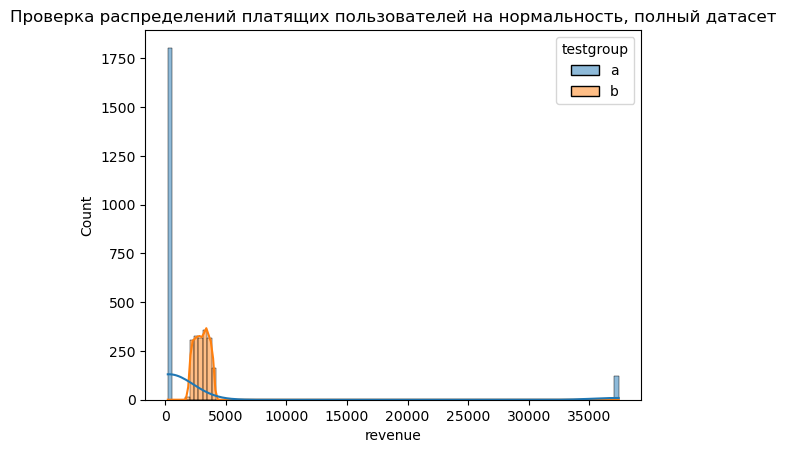

In [40]:
# Визаулизируем
sns.histplot(data=task2[(task2['revenue'] > 0)], x="revenue", hue="testgroup", kde=True)
plt.title('Проверка распределений платящих пользователей на нормальность, полный датасет')

In [43]:
# Проверим на нормальность для контрольной группы (нулевая гипотеза - распределение нормально)
control_data = task2[task2['testgroup'] == 'a']['revenue']

# Проверка нормальности распределения в контрольной группе
statistic, p_value = shapiro(control_data)

# Вывод результатов теста
if p_value < 0.05:
    print("Распределение контрольной группы не нормально, отвергаем нулевую гипотезу")
else:
    print("Распределение контрольной группы нормально, не отвергаем нулевую гипотезу")

Распределение контрольной группы не нормально, отвергаем нулевую гипотезу


In [42]:
# Проверим на нормальность для тестовой группы (нулевая гипотеза - распределение нормально)
test_data = task2[task2['testgroup'] == 'b']['revenue']

# Проверка нормальности распределения в тестовой группе
statistic, p_value = shapiro(test_data)

# Вывод результатов теста
if p_value < 0.05:
    print("Распределение тестовой группы не нормально, отвергаем нулевую гипотезу")
else:
    print("Распределение тестовой группы нормально, не отвергаем нулевую гипотезу")

Распределение тестовой группы не нормально, отвергаем нулевую гипотезу


2. Проверка на нормальность для платящих пользователей

In [44]:
# Проверим на нормальность для контрольной группы (нулевая гипотеза - распределение нормально)
control_data = task2[(task2['testgroup'] == 'a') & (task2['revenue'] > 0)]['revenue']

# Проверка нормальности распределения в контрольной группе
statistic, p_value = shapiro(control_data)

# Вывод результатов теста
if p_value < 0.05:
    print("Распределение контрольной группы не нормально, отвергаем нулевую гипотезу")
else:
    print("Распределение контрольной группы нормально, не отвергаем нулевую гипотезу")

Распределение контрольной группы не нормально, отвергаем нулевую гипотезу


In [45]:
# Проверим на нормальность для тестовой группы (нулевая гипотеза - распределение нормально)
test_data = task2[(task2['testgroup'] == 'b') & (task2['revenue'] > 0)]['revenue']

# Проверка нормальности распределения в тестовой группе
statistic, p_value = shapiro(test_data)

# Вывод результатов теста
if p_value < 0.05:
    print("Распределение тестовой группы не нормально, отвергаем нулевую гипотезу")
else:
    print("Распределение тестовой группы нормально, не отвергаем нулевую гипотезу")

Распределение тестовой группы не нормально, отвергаем нулевую гипотезу


Так же проверим на нормальность тестом Шапиро-Уилка

### Так как ни одно из распределений не нормально, воспользуемся тестом Мана-Уитни для проверки гипотез

### Для оценки результатов акции сравним несколько метрик - ARPU, ARPPU, Conversion Rate

#### 1. ARPU

In [40]:
test_data = task2.query('testgroup == "b"')
control_data = task2.query('testgroup == "a"')
test_data_pay = task2[(task2['testgroup'] == 'a') & (task2['revenue'] > 0)]
control_data_pay = task2[(task2['testgroup'] == 'b') & (task2['revenue'] > 0)]

In [41]:
arpu_contr = control_data.agg({'revenue': 'sum'}) / len(control_data)
arpu_test = test_data.agg({'revenue': 'sum'}) / len(test_data)
print("arpu_contr = ", round(arpu_contr[0], 2))
print("arpu_test = ", round(arpu_test[0], 2))

arpu_contr =  25.41
arpu_test =  26.75


In [42]:
arpu_contr[0]

25.413719736965806

In [43]:
# Проверим действительно ли ARPU отличается на заявленные проценты

print("ARPU в тестовой группе на", ((1 - task2.query('testgroup == "a"')
      .agg({'revenue': 'sum'}) / task2.query('testgroup == "b"')
      .agg({'revenue': 'sum'})) * 100).revenue.round(2), "% больше, чем в контрольной группе")

ARPU в тестовой группе на 5.26 % больше, чем в контрольной группе


Теперь проверим статистические различия между группами пользователей с помощью т-теста. Нулевая гипотеза - средние значения дохода в обеих группах равны. Альтернативная гипотеза - средние значения различаются

In [44]:
# Проведение t-теста
statistic, p_value = ttest_ind(test_data.revenue, control_data.revenue)

# Вывод результатов
print("Independent t-test:")
if p_value < 0.05:
    print("Принимаем альтернативную гипотезу, средние значения в тестовой и контрольной группах статистически различны")
else:
    print("Оставляем основную гипотезу, нет статистически значимых различий в средних значениях между группами")


Independent t-test:
Оставляем основную гипотезу, нет статистически значимых различий в средних значениях между группами


#### 2. ARPPU

In [45]:
arppu_contr = control_data_pay.agg({'revenue': 'sum'}) / len(control_data_pay)
arppu_test = test_data_pay.agg({'revenue': 'sum'}) / len(test_data_pay)
print("arppu_contr = ", round(arppu_contr[0], 2))
print("arppu_test = ", round(arppu_test[0], 2))

arppu_contr =  3003.66
arppu_test =  2664.0


In [46]:
# Проверим соотношение ARPPU

print("ARPPU в тестовой группе на", ((arppu_contr / arppu_test - 1) * 100)[0].round(2),
      "% меньше, чем в контрольной группе")

ARPPU в тестовой группе на 12.75 % меньше, чем в контрольной группе


Теперь проверим статистические различия между группами платящих пользователей с помощью т-теста. Нулевая гипотеза - средние значения дохода в обеих группах равны. Альтернативная гипотеза - средние значения различаются

In [47]:
# Проведение t-теста
statistic, p_value = ttest_ind(test_data_pay.revenue, control_data_pay.revenue)

# Вывод результатов
print("Independent t-test:")
if p_value < 0.05:
    print("Принимаем альтернативную гипотезу, средние значения в тестовой и контрольной группах статистически различны")
else:
    print("Оставляем основную гипотезу, нет статистически значимых различий в средних значениях между группами")


Independent t-test:
Оставляем основную гипотезу, нет статистически значимых различий в средних значениях между группами


#### 3. Conversion Rate

In [48]:
# Конверсия пользователей в контрольной группе
contr_len_pay = len(control_data_pay)
contr_len = len(control_data)
cr_contr = round((contr_len_pay / contr_len * 100), 2)
cr_contr

0.89

In [49]:
# Конверсия пользователей в тестовой группе
contr_len_pay = len(test_data_pay)
contr_len = len(test_data)
cr_test = round((contr_len_pay / contr_len * 100), 2)
cr_test

0.95

In [50]:
# Проверим соотношение CR

print("CR в тестовой группе на", round(((1 - cr_contr / cr_test) * 100), 2), "% больше, чем в контрольной группе")

CR в тестовой группе на 6.32 % больше, чем в контрольной группе


#### Между группами пользователей есть отличия. Проверим отличия между группами методом t-test и бутстрап чтобы исключить вероятность того что эти отличия случайны

Проверим статистические различия между группами пользователей с помощью т-теста. Нулевая гипотеза - средние значения дохода в обеих группах равны. Альтернативная гипотеза - средние значения различаются

In [51]:
# Проведение t-теста
statistic, p_value = ttest_ind(test_data.revenue, control_data.revenue)

# Вывод результатов
print("Independent t-test: p_value =", p_value)
if p_value < 0.05:
    print("Принимаем альтернативную гипотезу, средние значения в тестовой и контрольной группах статистически различны")
else:
    print("Оставляем основную гипотезу, нет статистически значимых различий в средних значениях между группами")


Independent t-test: p_value = 0.532494858971837
Оставляем основную гипотезу, нет статистически значимых различий в средних значениях между группами


Теперь проверим статистические различия между группами платящих пользователей с помощью т-теста. Нулевая гипотеза - средние значения дохода в обеих группах равны. Альтернативная гипотеза - средние значения различаются

In [52]:
# Проведение t-теста
statistic, p_value = ttest_ind(test_data_pay.revenue, control_data_pay.revenue)

# Вывод результатов
print("Independent t-test: p_value =", p_value)
if p_value < 0.05:
    print("Принимаем альтернативную гипотезу, средние значения в тестовой и контрольной группах статистически различны")
else:
    print("Оставляем основную гипотезу, нет статистически значимых различий в средних значениях между группами")


Independent t-test: p_value = 0.11153459157259495
Оставляем основную гипотезу, нет статистически значимых различий в средних значениях между группами


Так же проверим отличия между группами пользователей методом бутстрап

In [58]:
# Bootstrap
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки 
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1),
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

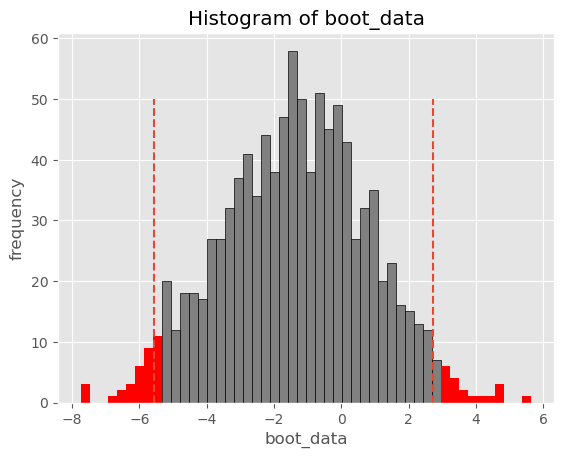

In [59]:
# по всем пользователям
booted_data = get_bootstrap(control_data.revenue, test_data.revenue)

In [60]:
booted_data["p_value"]  # альфа

0.5287658763744283

In [61]:
booted_data["quants"]  # ДИ

,0
0.025,-5.555883
0.975,2.739416


  0%|          | 0/1000 [00:00<?, ?it/s]

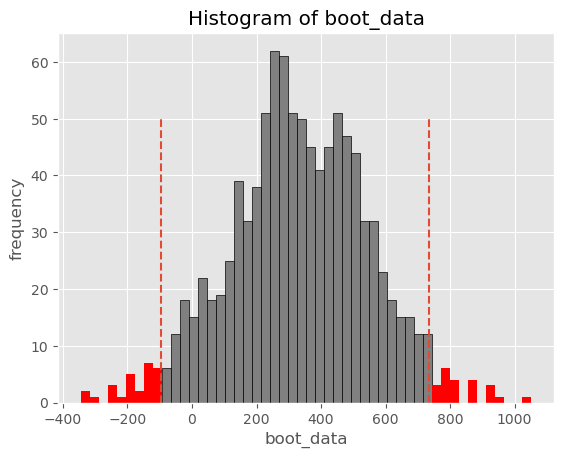

In [62]:
# По платящим пользователям
booted_data = get_bootstrap(control_data_pay.revenue, test_data_pay.revenue)

In [63]:
booted_data["p_value"]  # альфа

0.12057397628103218

In [64]:
booted_data["quants"]  # ДИ

,0
0.025,-97.620069
0.975,734.611759


# По итогам тестирования гипотез и исходя из имеющихся данных можно сделать следующие выводы:

## 1. В контрольной группе имеются выбросы. Их необходимо изучить дополнительно, если окажется что их необходимо исключить из наблюдений, то в тестовой группе почти все показатели выросли в 10 раз, выкатываем обновление

## 2. Если выбросы валидны, то тестирвания групп показали:
### - ARPPU в тестовой группе на 12.75 % меньше, чем в контрольной группе
### - ARPU в тестовой группе на 5.26 % больше, чем в контрольной группе
### - CR в тестовой группе на 6.32 % больше, чем в контрольной группе
### - Несмотря на отличия в ARPU, ARPPU, CR, между группами нет статистически значимых различий и по всем пользователям и по группам платящих пользователей по результатам и т-теста и по результатам бутстрапа средних
## С точки зрения результатов А/Б тестирования раскатывать обновление не имеет смысла, в зависимости от цели обновления необходимо принимать решение
## В зависимости от целей обновления вариант первый: сосредоточиться на платежеспособных клиентах которые формируют 90% доходов в контрольной группе - метод более рискованный т.к. при потере одного клиента прибыль падает ощутимо
## Вариант второй - сосредоточиться на тестовом варианте - на момент наблюдения прибыль немного меньше но распределена более равномерна, между всеми покупателями, и меньше рисков потерять прибыль. 



## На момент наблюдения второй вариант выглядит более предпочтительным, с увеличением количества покупателей возможно вырастет прибыль именно по нему. Но за неимением дополлнительной информации (даты покупок, динамика по прибыли, и т.д.) сделать однозначный вывод невозможно. Предлагаю дополнительно изучить выбросы, и продолжить наблюдения за группами


# Задание 3
# В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

# Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?


Для оценки результатов последнего события в игре предлагаю использовать следующие основные метрики:

1.	Доход от события(revenue) – метрика покажет финансовую эффективность события и прибыль от него
2.	Средний доход на участника(ARPU)
3.	Количество активных пользователей (MAU, DAU) 
4.	Количество участников события(в процентах от общего количества) – Метрика даст представление о популярности события
5.	Конверсия участников события в его завершение – метрика покажет насколько событие затягивает игроков
6.	Среднее время прохождения – метрика покажет сложность события и вовлеченность игроков
7.	Полученные награды( в случае если предполагается их выбор) – оценка количества и типов наград позволит оценить привлекательность конкретных наград и и популярность предметов и бонусов
8.	Отток пользователей – метрика покажет процент пользователей покинувших игру после обновления
9.	Удовлетворенность игроков (оценка события) – метрика покажет общее впечатление от события, в том числе относительно других событий
10.	Прохождение следующих событий – позволит оценить количество игроков которые участвуют в следующих событиях после прохождения текущего. Покажет влияние события на удержание игроков


Для оценки результатов после изменения механики игры в сторону отката на несколько уровней назад в случае неудачной попытки, предлагаю помимо основных метрик добавить следующие:

1.	Количество откатов в уровне – метрика покажет сложность события и требование к навыкам игрока
2.	Среднее количество попыток на уровень – если игрок откатывается на уровни, это может повлиять на количество попыток пройти событие
3.	Соотношение успешных и неуспешных попыток – метрика позволит оценить степень вовлеченности игрока при усложнении механики игры
4.	Отказы от события – процент отказов от продолжения прохождения события покажет недостаточность мотивации или сложность механики события
